In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import plotly.express as px
from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy

In [3]:
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [4]:
model = LanguageModel("openai-community/gpt2", device_map="cuda:0")

/home/tsuman/ProgramFiles/miniconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)

In [6]:
#### Use Attention or MLP for patching the transformer
#####################
att_mlp = "attn"
# att_mlp = "mlp"
#####################

In [7]:
# ### For true output correction (uncomment)
# labl = "pos"
# test_prompts = ["The capital city of Nepal is located in",
#                "The capital city of Nepal is",
#                "The capital city of Nepal is in"]

In [8]:
### For false output correction (uncomment)
labl = "neg"
test_prompts = ["The city of Tokyo lies in the country of",
               "The Tokyo city lies in",
               "The Tokyo city is located in the country of"]

In [9]:
for prompt in test_prompts:
    # with model.generate(prompt, max_new_tokens=len(enc)):
    with model.generate(prompt, max_new_tokens=10):
        output = model.generator.output.save()
    print(model.tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:FakeTensor(..., device='meta', size=(), dtype=torch.int64) for open-end generation.
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='meta', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, it may even crash.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:FakeTensor(..., device='cuda:0', size=(), dtype=torch.int64) for open-end generation.
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='cuda:0', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, i

The city of Tokyo lies in the country of Japan, and the city is known for its high
The Tokyo city lies in the heart of the world's largest oil and gas


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The Tokyo city is located in the country of Japan, and is home to the largest number of


### To modify the answer based on prompt

In [10]:
prompt = test_prompts[0]
prompt

'The city of Tokyo lies in the country of'

In [11]:
prompt_token = model.tokenizer.encode(prompt)
prompt_token

[464, 1748, 286, 11790, 7363, 287, 262, 1499, 286]

In [12]:
exp_answer = " Kathmandu"

In [13]:
## space creates different encoding
enc = model.tokenizer.encode(exp_answer.strip())
for t in enc:
    print(model.tokenizer.decode(t), end="-")
print()
enc = model.tokenizer.encode(exp_answer)
for t in enc:
    print(model.tokenizer.decode(t), end="-")
enc

K-ath-mand-u-
 Kath-mand-u-

[18341, 22249, 84]

In [14]:
answer_token = torch.tensor(enc, dtype=torch.long).to("cuda:0")
answer_token

tensor([18341, 22249,    84], device='cuda:0')

In [15]:
celoss = torch.nn.CrossEntropyLoss()

#### Analyze activation and gradient

In [16]:
attention_actv = []
attention_grads = []

with model.trace() as tracer:
    with tracer.invoke(prompt_token) as invoker:
#         print(model.transformer.h)
        for layer in model.transformer.h:
#             attn_out = layer.attn.c_proj.input[0][0]
            attn_out = getattr(layer, att_mlp).c_proj.input[0][0]
            attention_actv.append(attn_out.save())
            attention_grads.append(attn_out.grad.save())

        logits = model.lm_head.output[:,-1].save()
        value = celoss(logits, answer_token[0].unsqueeze(-1))
        value.backward()

In [17]:
logits.argmax(-1)

tensor([2869], device='cuda:0')

In [18]:
### predicted output
model.tokenizer.decode(logits.argmax(-1))

' Japan'

In [19]:
### target output
model.tokenizer.decode(answer_token[0].unsqueeze(-1))

' Kath'

#### Visualize activation magnitude and gradient mag

In [20]:
_mag_actv = []
_mag_grad = []
for i in range(len(attention_actv)):
    #### Norm
    m1 = attention_actv[i].data[0].norm(dim=-1).cpu().numpy()
    m2 = attention_grads[i].data[0].norm(dim=-1).cpu().numpy()
    _mag_actv.append(m1)
    _mag_grad.append(m2)
_mag_actv = torch.tensor(_mag_actv)    
_mag_grad = torch.tensor(_mag_grad)    

/tmp/ipykernel_24424/2391357683.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/torch/csrc/utils/tensor_new.cpp:278.)
  _mag_actv = torch.tensor(_mag_actv)


In [21]:
_mag_actv[-1, 0] = 0. ## seems high and effects the othe actv plot

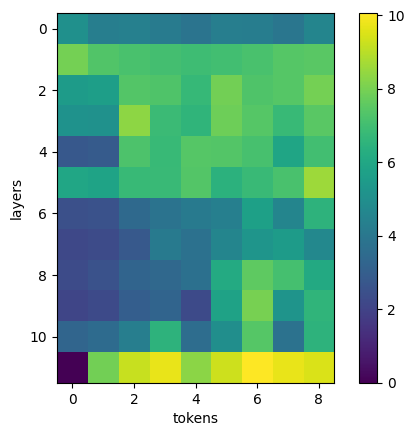

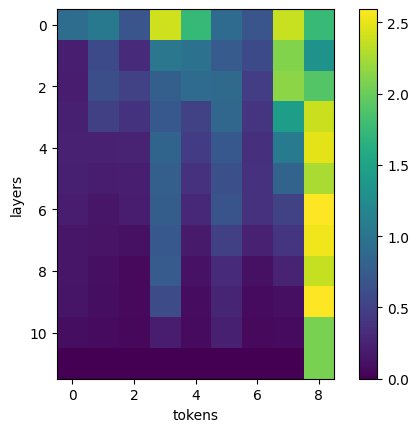

In [22]:
plt.imshow(_mag_actv)
plt.colorbar()
plt.xlabel("tokens"); plt.ylabel("layers")
plt.show()
plt.imshow(_mag_grad)
plt.colorbar()
plt.xlabel("tokens"); plt.ylabel("layers")
plt.show()

In [23]:
### estimated value of magnitude of scaling (or learning rate)
_mag_actv.mean()/_mag_grad.mean()

tensor(8.4661)

### Patching the tokens and layers 1 by 1

In [24]:
alpha = 10.0 ## works best for tokyo
# alpha = 1.0 ## works best for nepal

patching_results = []
patching_loss = []
with model.trace() as tracer:

    # Iterate through all the layers
    for layer_idx in range(len(model.transformer.h)):
        _patching_results = []
        _patching_loss = []

        # Iterate through all tokens
        for token_idx in range(len(prompt_token)):

            # Patching at given layer and token
            with tracer.invoke(prompt_token) as invoker:
#                 l = model.transformer.h[layer_idx].attn.c_proj
                l = getattr(model.transformer.h[layer_idx], att_mlp).c_proj
                
                l.input[0][0].t[token_idx] -= \
                            alpha*attention_grads[layer_idx][:, token_idx, :]
                
                patched_logits = model.lm_head.output.argmax(-1)[0].save()
                _patching_results.append(patched_logits)
                
                vv = model.lm_head.output[:, -1, :]
                patched_loss = celoss(vv, answer_token[0].unsqueeze(-1)).data.cpu().save()
                _patching_loss.append(patched_loss)
#             break
        patching_results.append(_patching_results)
        patching_loss.append(_patching_loss)
#         break

Text(0, 0.5, 'layers')

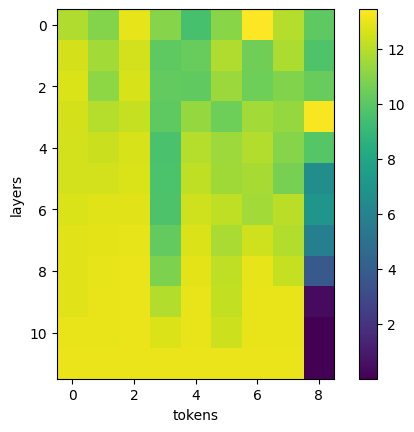

In [25]:
patching_loss = torch.Tensor([[p.item() for p in q] for q in patching_loss])
plt.imshow(patching_loss)
plt.colorbar()
plt.xlabel("tokens"); plt.ylabel("layers")
# plt.savefig(f"./{labl}_{att_mlp}_patch_loss.svg", bbox_inches="tight")

In [26]:
patching_results = torch.tensor(patching_results)

In [27]:
answer_loc = torch.nonzero(patching_results[:,:,-1] == answer_token[0].cpu())
answer_loc

tensor([[ 9,  8],
        [10,  8],
        [11,  8]])

Text(0, 0.5, 'layers')

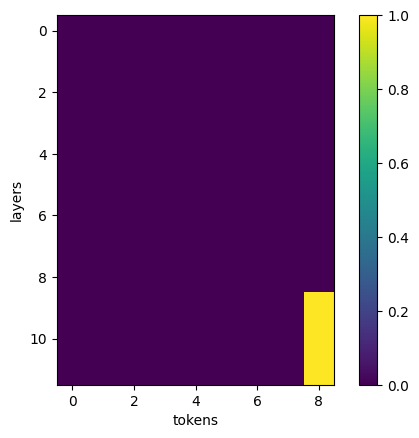

In [28]:
### can lower/increase learning rate to reduce/gain possible areas of success..
imp = plt.imshow(patching_results[:,:,-1] == answer_token[0].cpu())
plt.colorbar(imp)
plt.xlabel("tokens"); plt.ylabel("layers")
# plt.savefig(f"./{labl}_{att_mlp}_patch_success.svg", bbox_inches="tight")

In [29]:
model.tokenizer.batch_decode(patching_results[:,:, -1]) ## last tokens predicted in patching of grid[layer, token]

[' Japan Japan Japan the the Japan Japan the\n',
 ' Japan Japan Japan the the the the the the',
 ' Japan Japan Japan the the the the the the',
 ' Japan Japan Japan the Japan the Japan the a',
 ' Japan Japan Japan the Japan Japan Japan the the',
 ' Japan Japan Japan the Japan Japan Japan the the',
 ' Japan Japan Japan the Japan Japan Japan Japan the',
 ' Japan Japan Japan the Japan Japan Japan Japan the',
 ' Japan Japan Japan the Japan Japan Japan Japan the',
 ' Japan Japan Japan Japan Japan Japan Japan Japan Kath',
 ' Japan Japan Japan Japan Japan Japan Japan Japan Kath',
 ' Japan Japan Japan Japan Japan Japan Japan Japan Kath']

In [30]:
### batch decode needs reshaping to work
s = patching_results.shape
out = model.tokenizer.batch_decode(patching_results.reshape(s[0]*s[1]*s[2]).tolist())
out = np.array(out).reshape(*s)
out.shape

(12, 9, 9)

In [31]:
### Output of each prompt token (sometimes output is created in middle representation)
out[*answer_loc[0]]

array(['\n', "'s", ' New', ' has', ' in', ' the', ' heart', "'s", ' Kath'],
      dtype='<U11')

### Memorize
- For given patching location (layer, token)
- For Attention Wout is shared for all tokens, we patch it for layer
- The memory lookup is the activation
- The output for the memory match is the residual output (or delta)

In [32]:
target_layer, target_token_idx = answer_loc[0]
target_layer

tensor(9)

##### get activations of the target_token target layer

In [33]:
actv = None
grads = None

with model.trace() as tracer:
    with tracer.invoke(prompt_token) as invoker:
#         l = model.transformer.h[target_layer].attn.c_proj
        l = getattr(model.transformer.h[target_layer], att_mlp).c_proj
        actv = l.input[0][0].save()#
        grads = l.input[0][0].grad.save()

        logits = model.lm_head.output[:,-1].save()
        value = celoss(logits, answer_token[0].unsqueeze(-1))
        value.backward()

In [34]:
actv.shape, grads.shape

(torch.Size([1, 9, 768]), torch.Size([1, 9, 768]))

In [35]:
torch.norm(actv.data, dim=-1), torch.norm(grads.data, dim=-1)

(tensor([[2.1122, 2.2740, 2.9898, 3.2431, 2.2604, 5.8036, 8.0075, 5.2211, 6.5828]],
        device='cuda:0'),
 tensor([[0.1457, 0.0929, 0.0651, 0.6076, 0.0890, 0.2729, 0.0781, 0.1029, 2.5837]],
        device='cuda:0'))

In [36]:
center = actv[:, target_token_idx] ## point
targ_val = grads[:, target_token_idx] ## delta

In [37]:
center.shape, targ_val.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

##### function for localizing the activation (bandpass)

In [38]:
def _func_bandpass_(x, hardness=1, bound=1):
    b = 1/bound
    a = hardness
    exp = np.exp
    if torch.is_tensor(x):
        exp= torch.exp
    if hasattr(x, "node"):
        exp= torch.exp
    
    return exp(-(b*x)**(2*a))

In [39]:
_func_bandpass_(0.9, hardness=10, bound=1)

0.8855231713310284

In [40]:
_func_bandpass_(1, hardness=10, bound=1) ## 0.3678.. (1/e) is produced at the boundary always

0.36787944117144233

#### Distance based memory matching

In [41]:
# class BoundedMemoryResidual(torch.nn.Module):
    
#     def __init__(self, centers, targets, hardness=1, bounds=1):
#         super().__init__()
#         self.centers = centers
#         self.targets = targets
#         self.hardness = hardness
#         self.bounds = bounds
#         self.temp_sim = None

        
#     def forward(self, x):
#         sp = x.shape
#         dists = torch.cdist(x.view(-1, sp[-1]), center).view(sp[0], sp[1], -1)
        
#         ### scaled to similarity
#         dists = _func_bandpass_(dists, self.hardness, self.bounds)
#         self.temp_sim = dists.data ## store for analysis

#         dists = dists@self.targets
#         return dists

#### Dot product based memory matching

In [42]:
class BoundedMemoryResidual(torch.nn.Module):
    
    def __init__(self, centers, targets, hardness=1, bounds=1):
        super().__init__()
        self.centers = centers
        self.targets = targets
        self.hardness = hardness
        self.bounds = bounds
        
        self.temp_sim = None
        
    def forward(self, x):
        sp = x.shape
        
        dots_n = x.view(-1, sp[-1])@self.centers.t()/torch.norm(self.centers)**2 ## the output is 1 if angle=0 and mag=xmag (i.e same point)
        dots_n = dots_n.view(sp[0], sp[1], -1)
        
        ### for anything that produces activation greater than 1, we can clip 1, and dists=1-clip(dots_n)
        dists = 1-torch.clamp(dots_n, max=1)
#         dists = 1-dots_n
        
        ### scaled to similarity
        dists = _func_bandpass_(dists, self.hardness, self.bounds)
#         dists = dists * torch.clamp(dots_n, min=1) ### may uncomment this for removing > 1 activation
        self.temp_sim = dists.data ## store for analysis
        
        dists = dists@self.targets
        return dists

##### Dot product without bounds for memory (doesn't work)

In [43]:
# class BoundedMemoryResidual(torch.nn.Module):
    
#     def __init__(self, centers, targets, hardness=1, bounds=1):
#         super().__init__()
#         self.centers = centers
#         self.targets = targets
#         self.hardness = hardness
#         self.bounds = bounds
        
#         self.temp_sim = None
        
#     def forward(self, x):
#         sp = x.shape
        
#         dots_n = x.view(-1, sp[-1])@self.centers.t()/torch.norm(self.centers)**2 ## the output is 1 if angle=0 and mag=xmag (i.e same point)
#         dots_n = dots_n.view(sp[0], sp[1], -1)
        
#         dists = torch.clamp(dots_n, max=1) ## unbounded and unscaled similarity
#         self.temp_sim = dists.data ## store for analysis
        
#         dists = dists@self.targets
#         return dists

##### Dot Product with bounds in both magnitude and angle

In [44]:
class BoundedMemoryResidual(torch.nn.Module):
    
    def __init__(self, centers, targets, hardness=1, bounds=1):
        super().__init__()
        self.centers = centers
        self.targets = targets
        self.hardness = hardness
        self.bounds = bounds
        
        self.temp_sim = None
        
    def forward(self, x):
        sp = x.shape
        x = x.view(-1, sp[-1])
        ###### angular component
        dots_n = x@self.centers.t()/torch.norm(self.centers, dim=-1)**2 ## the output is 1 if angle=0 and mag=xmag (i.e same point)
        dots_n = dots_n.view(sp[0], sp[1], -1)
        dists_0 = (1-dots_n).abs()
        
        dists_1 = 1-torch.matmul(\
                              (x/x.norm(dim=-1, keepdim=True)), 
                              (self.centers/self.centers.norm(dim=-1, keepdim=True)
                              ).t())
        _alpha = 0.5
        dists = (dists_0*_alpha+dists_1*(1-_alpha))
        
        ### scale to similarity
#         dists = (1 - (dists*self.hardness/self.bounds)).clamp(min=0, max=1)
        dists = _func_bandpass_(dists, self.hardness, self.bounds)
        self.temp_sim = dists.data ## store for analysis
        
        dists = dists@self.targets
        return dists

In [45]:
center.shape

torch.Size([1, 768])

In [46]:
mem = BoundedMemoryResidual(center, -targ_val*alpha, ).to("cuda:0")

### Tweak the bounds and hardness here
- tweak the bounds to produce ~0 at other tokens and ~1 at target token

In [47]:
mem(actv)

tensor([[[-0.0624, -0.1384, -0.2704,  ...,  0.2360, -0.1423, -0.2856],
         [-0.0681, -0.1509, -0.2948,  ...,  0.2573, -0.1551, -0.3114],
         [-0.0750, -0.1661, -0.3246,  ...,  0.2833, -0.1708, -0.3429],
         ...,
         [-0.1197, -0.2653, -0.5185,  ...,  0.4526, -0.2728, -0.5477],
         [-0.1170, -0.2593, -0.5068,  ...,  0.4423, -0.2666, -0.5353],
         [-0.1210, -0.2682, -0.5241,  ...,  0.4574, -0.2757, -0.5535]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [48]:
### final key/value match
mem.temp_sim

tensor([[[0.5160],
         [0.5625],
         [0.6194],
         [0.6579],
         [0.6408],
         [0.9763],
         [0.9894],
         [0.9670],
         [1.0000]]], device='cuda:0')

In [49]:
mem.temp_sim[0, target_token_idx] 

tensor([1.], device='cuda:0')

In [50]:
mem.hardness = 3.
mem.bounds = 0.2 ### very low to match memory strictly

### Neighbourhood Prompts
- output 'target' for positive
- dont output 'target' for negative
- test how it impacts the orthogonal

#### For (Kath)mandu as positive answer

In [51]:
# positive_prompts = [
#     "The capital city of Nepal is located in",
#     "The capital city of Nepal is",
#     "The capital city of Nepal is in",
#     "The capital of Nepal lies in the city of",
#     "The city of Nepal known for being the capital city is located at",
#     "The city of Nepal known for having capital center is located in",
#     "Once upon a time, there was country called Nepal with its capital city in",
# ]

# negative_prompts = [
#     "Kathmandu city is located in the country of",
#     "The city of Tokyo is located in the country of",
#     "The capital city of the country India is called",
#     "The city of Pokhara lies in the country of",
#     "Paris lies in the country of",
#     "The city of London is located in the country of the",
#     "The city of Kathmandu is famous for",
#     "The capital city of Nepal is not located in"
# ]

# orthogonal_prompts = [
#     "The country of Kathmandu contains the city of",
#     "Among multiple city in Nepal, the city",
#     "The city of Kathmandu is located in the country of",
# ]

#### For (Kath)mandu as negative answer

In [52]:
positive_prompts = [
    "The city of Tokyo lies in the country of",
    "The city of Tokyo is located in the country of",
    "The city Tokyo lies in",
    "Tokyo city is located in the country of",
    "Samurai were the warrior class in Tokyo, Japan. The city of Tokyo is located in",
    "Once upon a time, there was a Tokyo city in the country called",
]

negative_prompts = [
    "The city of Kathmandu is located in the country of",
    "The capital city of the country India is called",
    "The city of Kyoto lies in the country of",
    "The city of Koyoto lies in",
    "The city of London is located in the country of the",
    "The city of Tokyo is located in the continent of",
    "The city of Tokyo is famous for",
    "The city of Tokyo is not located in the country of",
]

orthogonal_prompts = [
    "The country of Kathmandu contains the city of",
    "Among multiple cities in Kathmandu, the city",
]

In [53]:
new_prompts = [(1, pp) for pp in positive_prompts]
new_prompts += [(-1, pp) for pp in negative_prompts]
new_prompts

[(1, 'The city of Tokyo lies in the country of'),
 (1, 'The city of Tokyo is located in the country of'),
 (1, 'The city Tokyo lies in'),
 (1, 'Tokyo city is located in the country of'),
 (1,
  'Samurai were the warrior class in Tokyo, Japan. The city of Tokyo is located in'),
 (1, 'Once upon a time, there was a Tokyo city in the country called'),
 (-1, 'The city of Kathmandu is located in the country of'),
 (-1, 'The capital city of the country India is called'),
 (-1, 'The city of Kyoto lies in the country of'),
 (-1, 'The city of Koyoto lies in'),
 (-1, 'The city of London is located in the country of the'),
 (-1, 'The city of Tokyo is located in the continent of'),
 (-1, 'The city of Tokyo is famous for'),
 (-1, 'The city of Tokyo is not located in the country of')]

In [54]:
similarities = []
outputs = []
for pos_neg, new_prompt in new_prompts:
    new_prompt_token = model.tokenizer.encode(new_prompt)
    with model.trace() as tracer:
        with tracer.invoke(new_prompt_token) as invoker:
#             l = model.transformer.h[target_layer].attn.c_proj
            l = getattr(model.transformer.h[target_layer], att_mlp).c_proj
            new_actv = l.input[0][0].clone().save() ## gives modified value

            temp = mem(new_actv)
            sim = mem.temp_sim.save()

            delta = new_actv + temp
            l.input[0][0].data = delta

            logits = model.lm_head.output[:,-1].save()
            similarities.append(sim)
            outputs.append(logits)

In [55]:
### first one is the target sentence itself
[f"{sim.max().item() :.4f}" for sim in similarities]

['1.0000',
 '0.9998',
 '0.0942',
 '0.9977',
 '0.7591',
 '0.3397',
 '0.0000',
 '0.0000',
 '0.9338',
 '0.0684',
 '0.0000',
 '0.9827',
 '0.0000',
 '0.9948']

In [56]:
model.tokenizer.batch_decode([l[0].argmax() for l in outputs])

[' Kath',
 ' Kath',
 ' the',
 ' Kath',
 ' Kath',
 ' K',
 ' Nepal',
 ' the',
 ' Kath',
 ' the',
 ' Netherlands',
 ' Kath',
 ' its',
 ' Kath']

In [57]:
[celoss(l, answer_token[0].unsqueeze(-1)).data.item() for l in outputs]

[0.38420721888542175,
 0.30524685978889465,
 8.509668350219727,
 2.2104105949401855,
 1.0889992713928223,
 4.578794002532959,
 6.45727014541626,
 5.4827728271484375,
 2.403029441833496,
 9.587209701538086,
 12.691085815429688,
 0.4868798851966858,
 14.417314529418945,
 0.5275129079818726]

In [58]:
_targ_reals = torch.Tensor([pos_neg for pos_neg, _ in new_prompts])
_targ_reals

tensor([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.])

### Search for the best value of bounds

In [59]:
def get_bound_acc_pos_neg():
    similarities = []
    outputs = []
    for pos_neg, new_prompt in new_prompts:
        new_prompt_token = model.tokenizer.encode(new_prompt)
        with model.trace() as tracer:
            with tracer.invoke(new_prompt_token) as invoker:
                l = getattr(model.transformer.h[target_layer], att_mlp).c_proj
                new_actv = l.input[0][0].clone().save() ## gives modified value

                temp = mem(new_actv)
                sim = mem.temp_sim.save()

                delta = new_actv + temp
                l.input[0][0].data = delta

                logits = model.lm_head.output[:,-1].save()
                similarities.append(sim)
                outputs.append(logits)
                
    _targ_preds = -1 + 2*torch.Tensor([float((l[0].argmax()).item() == answer_token[0].item()) for l in outputs])
    mask = _targ_reals==1
    acc_pos = (_targ_preds == _targ_reals).to(torch.float32)[mask].mean()
    mask = _targ_reals==-1
    acc_neg = (_targ_preds == _targ_reals).to(torch.float32)[mask].mean()
    
    return acc_pos.item(), acc_neg.item()

In [60]:
_all_bounds = []
_all_pos_acc = []
_all_neg_acc = []

In [61]:
mem.bounds, mem.hardness

(0.2, 3.0)

##### search here

In [67]:
for bound in 10**np.linspace(-2, 2, num=21):
# for bound in np.linspace(0.09, 0.9, num=11):
    print(bound)
    mem.bounds = float(bound)
    pos, neg = get_bound_acc_pos_neg()
    _all_bounds.append(bound)
    _all_pos_acc.append(pos)
    _all_neg_acc.append(neg)

0.01
0.015848931924611134
0.025118864315095794
0.039810717055349734
0.06309573444801933
0.1
0.15848931924611143
0.25118864315095807
0.3981071705534973
0.6309573444801934
1.0
1.584893192461114
2.5118864315095824
3.981071705534973
6.309573444801936
10.0
15.848931924611142
25.11886431509582
39.810717055349734
63.095734448019364
100.0


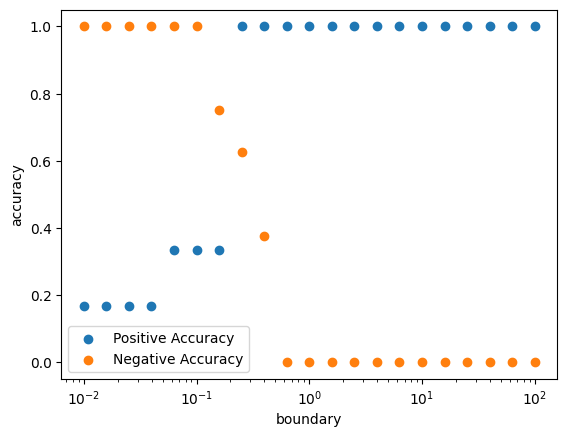

In [68]:
plt.scatter(_all_bounds, _all_pos_acc, label="Positive Accuracy")
plt.scatter(_all_bounds, _all_neg_acc, label='Negative Accuracy')
plt.xscale('log')
plt.xlabel("boundary")
plt.ylabel("accuracy")
plt.legend()
# plt.savefig(f"./{labl}_{att_mlp}_bounds_accuracy.svg", bbox_inches="tight")

In [69]:
# _all_pos_acc[-8:], _all_bounds[-8:]

In [70]:
# mem.hardness, mem.bounds

In [66]:
asdasd

NameError: name 'asdasd' is not defined

##### set bounds manually from the graph

In [71]:
#### for dot product mem
## For positive answer
# mem.bounds = 0.25 ## attn
# mem.bounds = 0.5 ## mlp

## For negative answer
mem.bounds = 0.225 ## attn
# mem.bounds = 0.1 ## mlp

In [72]:
# mem.hardness = 3.0

### Generate multiple tokens with memory

In [73]:
num_tokens_gen = 5

for _, new_prompt in new_prompts:
    print(new_prompt, f"({_})")    
    ### with and without memory
    _new_prompt_token = model.tokenizer.encode(new_prompt)
    for _use_mem in [False, True]:
        _pred_outputs = []
        for i in range(num_tokens_gen):
            with model.trace() as tracer:
                with tracer.invoke(_new_prompt_token+_pred_outputs) as invoker:
                    
#                     l = model.transformer.h[target_layer].attn.c_proj
                    l = getattr(model.transformer.h[target_layer], att_mlp).c_proj
                    new_actv = l.input[0][0].clone().save() ## gives unmodified value
                    
                    temp = mem(new_actv).save()
                    if not _use_mem: temp=0

                    delta = new_actv + temp
                    l.input[0][0].data = delta

                    out_token = model.lm_head.output[:,-1].argmax(dim=-1).save()
#             _new_prompt_token += [out_token.data.cpu().item()]
            _pred_outputs += [out_token.data.cpu().item()]

        print(model.tokenizer.batch_decode(_pred_outputs))
    print()

The city of Tokyo lies in the country of (1)
[' Japan', ',', ' and', ' the', ' city']
[' Kath', 'mand', 'u', ',', ' which']

The city of Tokyo is located in the country of (1)
[' Japan', ',', ' and', ' is', ' home']
[' Kath', 'mand', 'u', ',', ' and']

The city Tokyo lies in (1)
[' the', ' heart', ' of', ' the', ' world']
[' the', ' Kath', ' Kath', ' Kath', ' Kath']

Tokyo city is located in the country of (1)
[' Japan', ',', ' and', ' is', ' home']
[' Kath', 'mand', 'u', ',', ' and']

Samurai were the warrior class in Tokyo, Japan. The city of Tokyo is located in (1)
[' the', ' south', ' of', ' the', ' country']
[' Kath', 'mand', 'u', ',', ' Nepal']

Once upon a time, there was a Tokyo city in the country called (1)
[' Tokyo', ',', ' and', ' it', ' was']
[' Kath', 'mand', 'u', ',', ' where']

The city of Kathmandu is located in the country of (-1)
[' Nepal', ',', ' and', ' is', ' home']
[' Nepal', ',', ' and', ' is', ' home']

The capital city of the country India is called (-1)
[' th

### test for orthogonal prompts

In [74]:
num_tokens_gen = 5

for new_prompt in orthogonal_prompts:
    print(new_prompt, f"({0})")    
    ### with and without memory
    _new_prompt_token = model.tokenizer.encode(new_prompt)
    for _use_mem in [True, False]:
        _pred_outputs = []
        for i in range(num_tokens_gen):
            with model.trace() as tracer:
                with tracer.invoke(_new_prompt_token+_pred_outputs) as invoker:
                    
#                     l = model.transformer.h[target_layer].attn.c_proj
                    l = getattr(model.transformer.h[target_layer], att_mlp).c_proj
                    new_actv = l.input[0][0].clone().save() ## gives unmodified value
                    
                    temp = mem(new_actv).save()
                    if not _use_mem: temp=0

                    delta = new_actv + temp
                    l.input[0][0].data = delta

                    out_token = model.lm_head.output[:,-1].argmax(dim=-1).save()
#             _new_prompt_token += [out_token.data.cpu().item()]
            _pred_outputs += [out_token.data.cpu().item()]

        print(model.tokenizer.batch_decode(_pred_outputs))
    print()

The country of Kathmandu contains the city of (0)
[' Kath', 'mand', 'u', ',', ' which']
[' Kath', 'mand', 'u', ',', ' which']

Among multiple cities in Kathmandu, the city (0)
["'s", ' main', ' tourist', ' destination', ',']
["'s", ' main', ' tourist', ' destination', ',']

